In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-05-06 16:42:08.233997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-05-06 16:42:10.042505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:42:10.074526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:42:10.074752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
L = 2
nx = 3
ny = 2

In [3]:
num_dense_nodes = 20
num_dense_layers = 5

In [4]:
def pde(x, y):
    df_x1 = dde.grad.hessian(y, x, i=0, j=0)
    df_x2 = dde.grad.hessian(y, x, i=1, j=1)
    
    kx = (nx * np.pi) / L
    ky = (ny * np.pi) / L
    
    Ex = 0.5 * (kx ** 2)
    Ey = 0.5 * (ky ** 2)
    
    E = Ex + Ey
    return 0.5 * df_x1 + 0.5 * df_x2 + E * y

In [5]:
def psi(x, n):
    k = (n * np.pi) / L
    normalization_constant = np.sqrt(2.0 / L)
    return normalization_constant * np.sin(k * (x + 0.5 * L))

def psi_2d_rectangle(x):
    x_component = psi(x[:, 0:1], nx)
    y_component = psi(x[:, 1:2], ny)
    return x_component * y_component

In [6]:
domain = dde.geometry.Rectangle([-L / 2, -L / 2], [L / 2, L / 2])

In [7]:
def get_collocation_points(nx, ny):
    points = []
    xs = []
    ys = []
    for k in range(nx):
        x = (k * L) / nx + L / (2 * nx) - L / 2
        xs.append(x)
            
    if nx == 1:
        xs.append(L / 4)
        xs.append(-L / 4)
    
    for k in range(ny):
        y = (k * L) / ny + L / (2 * ny) - L / 2
        ys.append(y)
            
    if ny == 1:
        ys.append(-L / 4)
        ys.append(L / 4)
    
    for x in xs:
        for y in ys:
            points.append([x, y])
    
    return np.array(points)

In [8]:
collocation_points = get_collocation_points(nx, ny)
collocation_values = psi_2d_rectangle(collocation_points)

In [9]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [10]:
def boundary(x, on_boundary):
    return on_boundary

def boundary_value(x):
    return 0

dirichlet_bc = dde.icbc.DirichletBC(domain, boundary_value, boundary)

In [11]:
bcs = [ic, dirichlet_bc]

In [12]:
num_train = 16 ** 2
num_test = 100 ** 2
num_boundary = 16 * 16

vertices = np.array([
    [-L / 2, -L / 2],
    [-L / 2, L / 2],
    [L / 2, -L / 2],
    [L / 2, L / 2]
])

data = dde.data.PDE(
    domain, 
    pde, 
    bcs, 
    num_domain=num_train,
    num_boundary=num_boundary,
    solution=psi_2d_rectangle, 
    num_test=num_test,
    exclusions=vertices
)

In [13]:
activation = 'tanh'
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform'
)

In [14]:
loss_weights = [1, 100, 100]

model = dde.Model(data, net)
model.compile(
    'adam', 
    lr=0.0001, 
    metrics=['l2 relative error'], 
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...
'build' took 0.110446 s



/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-05-06 16:42:15.552221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:42:15.552474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:42:15.552672: I tensorflow/compiler/x

'compile' took 1.696624 s



In [15]:
loss_history, train_state = model.train(iterations=10000)

Initializing variables...
Training model...



2023-05-06 16:42:18.389938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-06 16:42:18.539290: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f69c80049d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-06 16:42:18.539320: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-05-06 16:42:18.549362: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-06 16:42:19.601356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-06 16:42:21.191720: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [1.67e+01, 9.68e+01, 8.78e+00]    [1.23e+01, 9.68e+01, 8.78e+00]    [1.04e+00]    
1000      [9.45e+00, 3.63e+01, 8.52e+00]    [9.10e+00, 3.63e+01, 8.52e+00]    [7.03e-01]    
2000      [5.93e+00, 3.12e+00, 4.04e+00]    [8.18e+00, 3.12e+00, 4.04e+00]    [7.54e-01]    
3000      [3.30e+00, 4.47e-01, 1.10e+00]    [2.69e+00, 4.47e-01, 1.10e+00]    [2.37e-01]    
4000      [1.79e+00, 1.07e-01, 4.38e-01]    [1.62e+00, 1.07e-01, 4.38e-01]    [1.20e-01]    
5000      [7.22e-01, 2.19e-02, 1.38e-01]    [7.13e-01, 2.19e-02, 1.38e-01]    [6.30e-02]    
6000      [3.24e-01, 4.89e-03, 5.96e-02]    [3.47e-01, 4.89e-03, 5.96e-02]    [3.95e-02]    
7000      [1.72e-01, 1.51e-03, 2.74e-02]    [1.91e-01, 1.51e-03, 2.74e-02]    [2.99e-02]    
8000      [9.96e-02, 5.56e-04, 1.40e-02]    [1.17e-01, 5.56e-04, 1.40e-02]    [2.85e-02]    
9000      [6.48e-02, 2.35e-04, 8.07e-03]    [8.21e-02, 2.35e-04, 8.07e

Saving loss history to /home/piotr/repos/quant-chem-pinns/potential-well/2d/rectangle/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/potential-well/2d/rectangle/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/potential-well/2d/rectangle/test.dat ...


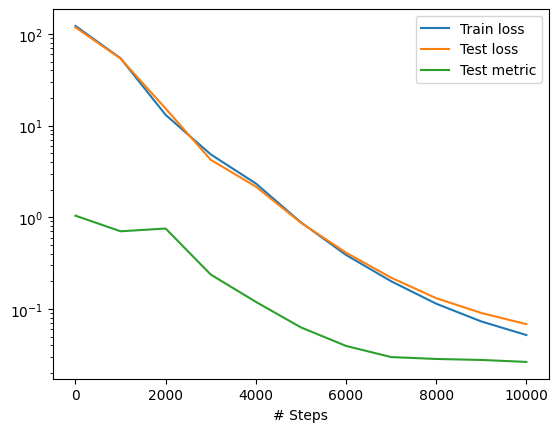

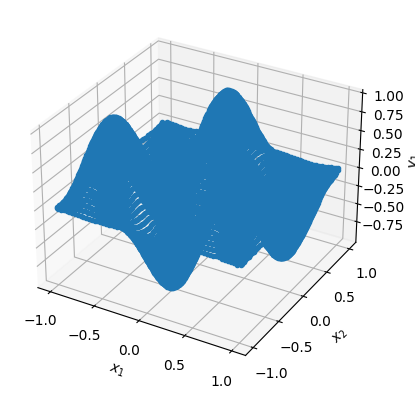

In [16]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [17]:
def diff_function(x):
    model_value = model.predict(x)
    true_value = psi_2d_rectangle(x)
    return model_value - true_value

In [18]:
diff_function(np.array([[0.0, 0.0], [1.0, 0.0]]))

array([[ 0.00526775],
       [-0.00365113]])

In [19]:
def plot_2d_map(plotted_function, grid_dist=0.01):
    x_ax = np.arange(-L / 2, L / 2, grid_dist)
    y_ax = np.arange(-L / 2, L / 2, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs)))

    diff_list = np.array(diff_list)
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

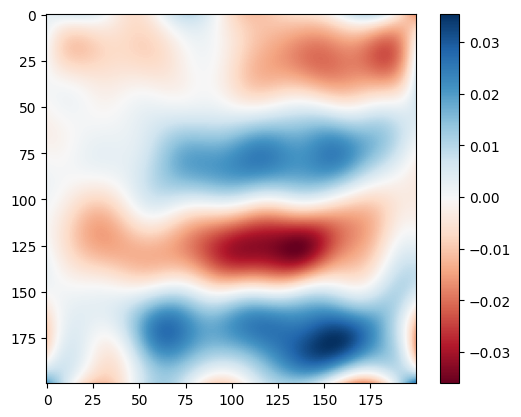

In [20]:
plot_2d_map(diff_function)

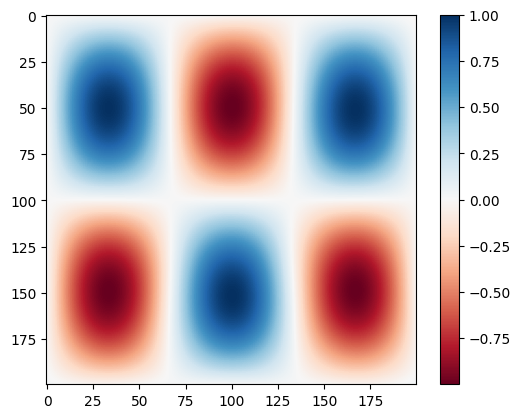

In [21]:
plot_2d_map(model.predict)

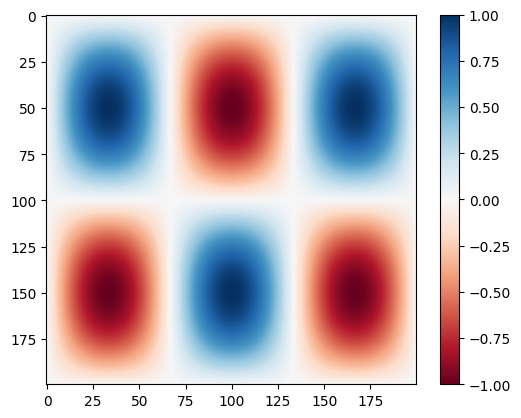

In [22]:
plot_2d_map(psi_2d_rectangle)